in a homogenous fluid

From Masked data?

In [1]:
from_masked = False

Imports

In [2]:
import pickle
import os
import My_functions as Mf
import numpy as np
import scipy
from scipy.constants import g, pi
import matplotlib.pyplot as plt

c:\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


sphere attributes

In [3]:
sphere_diameter = 9.525/1000 #m
rho_sphere = 1110
sphere_volume = 4/3*pi*sphere_diameter**3
mass = rho_sphere*sphere_volume
steady_state_drag_force = mass*g
print('steady_state_drag_force = ', steady_state_drag_force, '[N]')

steady_state_drag_force =  0.039402812013620704 [N]


In [4]:
parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output', 'Multy')

pic_folder = os.path.join(parent_folder,'Picture', 'alot')
multy_cut_image = 'multy_cut_image'
if from_masked:
    multy_cut_image = multy_cut_image+ '_masked'
multy_cut_image_folder = os.path.join(save_folder, multy_cut_image)


name_of_file = 'locations_from_PIV.pkl'
if from_masked:
    name_of_file = name_of_file[:-4] + '_Mask.pkl'

file_path = os.path.join(save_folder, name_of_file)
with open(file_path, 'rb') as file:
    sphere_location, sphere_velocity, PIV_origin_location, Selected_area_for_PIV, scaling_factor, object_range = pickle.load(file)

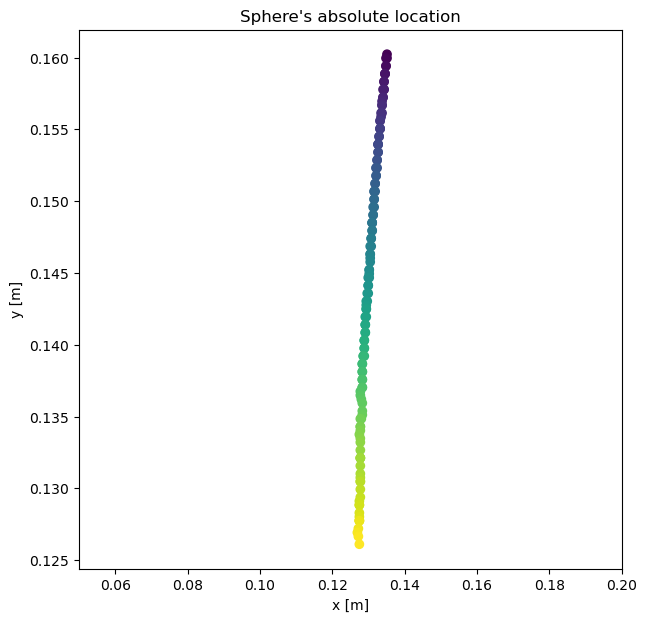

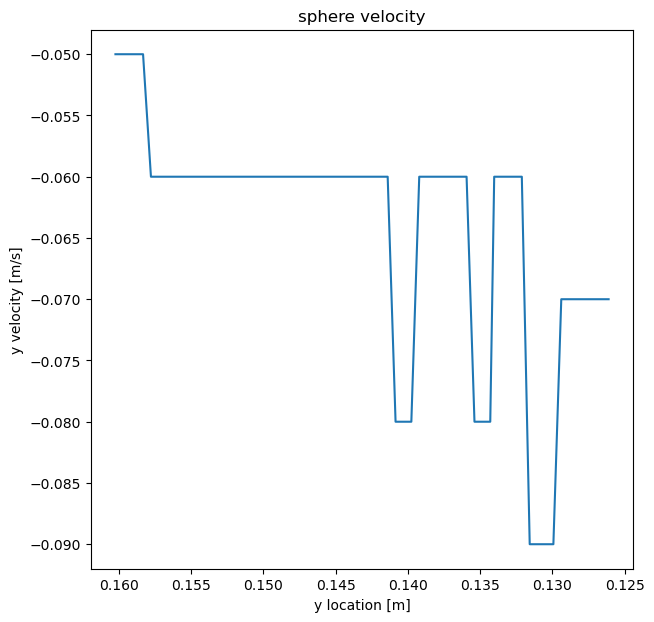

In [5]:
sphere_location = np.array(sphere_location)
sphere_velocity = np.array(sphere_velocity)
x_axis = sphere_location[:, 0]
y_axis = sphere_location[:, 1]
y_velocity = sphere_velocity[:, 1]



fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(x_axis, y_axis, c = np.arange(0, 1, 1/len(y_axis)))

# #plot vertical lines
# plt.axvline(x=sphere_location[0][0], color='red')
# plt.axvline(x=sphere_location[-1][0], color='red')
# # plt.axhline(y=y_point, color='blue', linestyle='--')

ax.set_xlim(0.05,0.2)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.title("Sphere's absolute location")
plt.show()
# plt.clf()






fig, ax = plt.subplots(figsize=(7,7))

# plt.scatter(y_axis, y_velocity, c = np.arange(0, 1, 1/len(y_axis)))
plt.plot(y_axis, y_velocity)

plt.title("sphere velocity")
# ax.set_xlim(0.1,0.14)
# ax.set_ylim(0.07, 0.08)
ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity [m/s]')
plt.gca().invert_xaxis()
plt.show()

$\color{red}$ Now we will set the sphere location with respect to PIV rectangle origin bottom left corner

In [6]:
#make "sphere location" origin (0,0) same as PIV origin (0,0)
sphere_location_fixed=[]
for ind,el in enumerate(sphere_location):
    sphere_location_fixed.append([el[0]-PIV_origin_location[ind][0], el[1]-PIV_origin_location[ind][1]])
    # sphere_location_fixed2.append(el-PIV_selecion[0])

sphere_location = sphere_location_fixed
sphere_location_fixed = 0
# from bottom left in pixel
sphere_location_pixel = np.array(sphere_location)*scaling_factor

In [7]:
F_y = []
b = 2*sphere_diameter
rho_1 = 1090

txt_files_path = Mf.files_in_folder(save_folder, 'txt', full_path = True)
txt_files_path_1 = []


for el in txt_files_path:
    if from_masked:
        if "masked" in el:
            txt_files_path_1.append(el)
    else:
        if not "masked" in el:
            txt_files_path_1.append(el)

txt_files_path = txt_files_path_1
txt_files_path_1 = 0

The force acting on the water

<img title="Control Volume Integral" alt="Alt text" src="../Picture/IMG for markdown/control_vol_int.png">

Plot the spheres?

In [8]:
show = False

we need to find the relevant place in Y for sum1 and sum2, and to cut the list for -2a<x<2a

In [9]:
if show:
    pictures_list = Mf.find_pictures(multy_cut_image_folder, full_path = True)
    print("the red dot is the sphere's location With respect to the bottom left corner")


for ind, el in enumerate(sphere_location):
    x, y, u, v = Mf.txt_to_column(txt_files_path[ind])
    
    start_y_upper, end_y_upper = Mf.find_closest_range_to_values_in_array(y, sphere_location[ind][1] + b)
    start_y_lower, end_y_lower = Mf.find_closest_range_to_values_in_array(y, sphere_location[ind][1] - b)
    start_x, end_x = Mf.find_closest_values_in_array(x, sphere_location[ind][0] - 2*sphere_diameter), Mf.find_closest_values_in_array(x, sphere_location[ind][0] + 2*sphere_diameter)
    
    v_sum_upper = v[start_y_upper: end_y_upper][start_x: end_x] # [m/s]
    v_sum_lower = v[start_y_lower: end_y_lower][start_x: end_x] # [m/s]

    x_values = x[start_x: end_x] # [m]

    #note: sphere_velocity[ind][1] is the control volume velocity V_c
    w_squared_upper = (np.array(v_sum_upper)-sphere_velocity[ind][1])**2 # [m^2 / s^2]
    w_squared_lower = (np.array(v_sum_lower)-sphere_velocity[ind][1])**2 # [m^2 / s^2]
    
    sum_upper = scipy.integrate.trapz(w_squared_upper, x_values)
    sum_lower = scipy.integrate.trapz(w_squared_lower, x_values)


    # the force acting on the WATER:
    F_y_el = 4*sphere_diameter*(rho_1*sum_upper - rho_1*sum_lower)

    # appending the force acting on the SPHERE not on the water:
    F_y.append(-F_y_el)
    
    if show:
        fig, ax = plt.subplots(figsize=(7,7))
        img = Mf.read_image(pictures_list[ind], gray = True)
        imgy = np.copy(img)[::-1]
        # img.shape[0] => Y dimentions and img.shape[1] => X dimentions
        plt.imshow(imgy, cmap='gray', origin='lower', extent = (0, img.shape[1]/scaling_factor, 0, img.shape[0]/scaling_factor)) # make sure the origin is left bottom corner
        plt.scatter(sphere_location[ind][0], sphere_location[ind][1], s = 100, c = 'red')
        plt.title(os.path.basename(pictures_list[ind]))
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        plt.show()

הנקודה האדומה מציינת את מרכז הכדור, נראה שהיא לא בדיוק באמצע ויש 2 סיבות עיקריות

1) מיקום הנקודה האדומה זה אינטרפולציה לינארית בין 2 תמונות
2) האלגוריתם לא מוצא את המרכז בצורה מושלמת, בעיקר בשכבת המעבר כאשר יש שוני באינדקסי שבירה, הכדור מתעוות והאלגוריתם מוצא את מה שהכי קרוב
3) סביר מאוד שהמרכז לא נופל בפיקסל שלם, למשל הוא נמצא בפיקסלים (10.21, 10.68) ואי אפשר לייצג את זה כי חייב לבחור נקודה שתיהיה בפיקסל ספציפי ( במספר שלם) אז המחשב יציג לנו אותו ב (10,10)

In [10]:
save_file_name = 'Force_from_control_volume.pkl'
if from_masked:
    save_file_name = save_file_name[:-4] + '_Mask.pkl'
file_path = os.path.join(save_folder, save_file_name)
with open(file_path, 'wb') as file:
    pickle.dump(F_y, file)

std = np.std(F_y)
average = np.average(F_y)


buoyancy = rho_1*sphere_volume*g

print('average F_y : ', average, '\nstd : ', std, '\nmg : ', -mass*g, '\nbuoyancy : ', buoyancy, '\nbuoyancy + F_Y (PIV) : ', buoyancy + average)
print('mg-F_b-F_d = 0 , should be 0   but:  ', mass*g-(buoyancy + average), 'not zero')

average F_y :  9.033091347097761e-05 
std :  0.00018424315835989988 
mg :  -0.039402812013620704 
buoyancy :  0.03869285143679871 
buoyancy + F_Y (PIV) :  0.03878318235026969
mg-F_b-F_d = 0 , should be 0   but:   0.0006196296633510165 not zero


In [11]:
# Mf.display_images_as_video(multy_cut_image_folder, scatter = sphere_location_pixel, origin = 'bottom-left')